# NdLinear vs. Standard Linear Layers in Transformer Models

This notebook demonstrates the benefits of using NdLinear as a replacement for standard nn.Linear layers in transformer models. We'll compare parameter count, training efficiency, and model performance between the two approaches.

## Overview

NdLinear is designed to preserve multi-dimensional structure of data by applying transformations across dimensions while maintaining tensor shape. This makes it more parameter-efficient than standard linear layers while potentially improving model performance.

In this notebook, we will:
1. Load and prepare a text classification dataset
2. Implement a baseline transformer model with standard nn.Linear layers
3. Implement a modified transformer model using NdLinear
4. Compare the models in terms of parameter count, training time, and performance
5. Visualize the results

## 1. Setup and Imports

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [2]:
!pip install ndlinear

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from datasets import load_dataset

# Import NdLinear
from ndlinear import NdLinear

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Prepare Dataset

We'll use the AG News dataset, which is a collection of news articles categorized into 4 classes: World, Sports, Business, and Sci/Tech.

In [4]:
# Load AG News dataset
dataset = load_dataset("ag_news")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [5]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Set maximum sequence length
max_length = 128

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=max_length)

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Convert to PyTorch format
tokenized_datasets = tokenized_datasets.with_format("torch")

# Create train and test datasets
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

# Create smaller dataset for faster experimentation
train_size = 10000  # Adjust as needed
test_size = 1000    # Adjust as needed

train_subset = train_dataset.shuffle(seed=42).select(range(train_size))
test_subset = test_dataset.shuffle(seed=42).select(range(test_size))

print(f"Train dataset size: {len(train_subset)}")
print(f"Test dataset size: {len(test_subset)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Train dataset size: 10000
Test dataset size: 1000


In [6]:
# Create DataLoaders
batch_size = 32

train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=batch_size)

## 3. Implement Baseline Transformer Model with Standard Linear Layers

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Standard Linear layers for Q, K, V projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        # Reshape to [batch_size, seq_length, num_heads, d_k]
        x = x.view(batch_size, -1, self.num_heads, self.d_k)
        # Transpose to [batch_size, num_heads, seq_length, d_k]
        return x.transpose(1, 2)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Linear projections
        q = self.W_q(q)
        k = self.W_k(k)
        v = self.W_v(v)

        # Split heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            # Fix: Reshape mask to match scores dimensions [batch_size, num_heads, seq_length, seq_length]
            # Assuming mask is [batch_size, seq_length] or [batch_size, 1, seq_length]
            if mask.dim() == 2:
                # If mask is [batch_size, seq_length], expand it to [batch_size, 1, 1, seq_length]
                mask = mask.unsqueeze(1).unsqueeze(2)
            elif mask.dim() == 3:
                # If mask is [batch_size, 1, seq_length], expand it to [batch_size, 1, 1, seq_length]
                mask = mask.unsqueeze(1)

            # Expand mask to match scores dimensions
            mask = mask.expand_as(scores)
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, v)

        # Combine heads
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Final linear projection
        output = self.W_o(context)

        return output

In [8]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        # Standard Linear layers for feed-forward network
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention with residual connection and normalization
        attn_output = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed-forward with residual connection and normalization
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [11]:
class StandardTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, num_classes, max_seq_length, dropout=0.1):
        super(StandardTransformer, self).__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, mask=None):
        # x shape: [batch_size, seq_length]

        # Embedding and positional encoding
        x = self.embedding(x)  # [batch_size, seq_length, d_model]
        x = self.positional_encoding(x)
        x = self.dropout(x)

        # Encoder layers
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, mask)

        # Global average pooling
        x = torch.mean(x, dim=1)  # [batch_size, d_model]

        # Classification layer
        output = self.fc(x)  # [batch_size, num_classes]

        return output

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## 4. Implement Transformer Model with NdLinear Layers

In [12]:
class NdMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(NdMultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # NdLinear layers for Q, K, V projections
        # Reshape input to preserve structure: [batch_size, seq_length, d_model] -> [batch_size, seq_length, d_model/num_heads, num_heads]
        self.W_q = NdLinear(input_dims=(d_model//num_heads, num_heads), hidden_size=(d_model//num_heads, num_heads))
        self.W_k = NdLinear(input_dims=(d_model//num_heads, num_heads), hidden_size=(d_model//num_heads, num_heads))
        self.W_v = NdLinear(input_dims=(d_model//num_heads, num_heads), hidden_size=(d_model//num_heads, num_heads))
        self.W_o = NdLinear(input_dims=(d_model//num_heads, num_heads), hidden_size=(d_model//num_heads, num_heads))

    def reshape_for_ndlinear(self, x, batch_size):
        # Reshape from [batch_size, seq_length, d_model] to [batch_size * seq_length, d_model//num_heads, num_heads]
        seq_length = x.size(1)
        return x.view(batch_size * seq_length, self.d_model // self.num_heads, self.num_heads)

    def reshape_from_ndlinear(self, x, batch_size):
        # Reshape back from [batch_size * seq_length, d_model//num_heads, num_heads] to [batch_size, seq_length, d_model]
        seq_length = x.size(0) // batch_size
        return x.view(batch_size, seq_length, self.d_model)

    def split_heads(self, x, batch_size):
        # Reshape to [batch_size, seq_length, num_heads, d_k]
        seq_length = x.size(1)
        x = x.view(batch_size, seq_length, self.num_heads, self.d_k)
        # Transpose to [batch_size, num_heads, seq_length, d_k]
        return x.transpose(1, 2)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        seq_length = q.size(1)

        # Reshape for NdLinear
        q_reshaped = self.reshape_for_ndlinear(q, batch_size)
        k_reshaped = self.reshape_for_ndlinear(k, batch_size)
        v_reshaped = self.reshape_for_ndlinear(v, batch_size)

        # NdLinear projections
        q_projected = self.W_q(q_reshaped)
        k_projected = self.W_k(k_reshaped)
        v_projected = self.W_v(v_reshaped)

        # Reshape back
        q = self.reshape_from_ndlinear(q_projected, batch_size)
        k = self.reshape_from_ndlinear(k_projected, batch_size)
        v = self.reshape_from_ndlinear(v_projected, batch_size)

        # Split heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            # Fix: Reshape mask to match scores dimensions [batch_size, num_heads, seq_length, seq_length]
            # Assuming mask is [batch_size, seq_length] or [batch_size, 1, seq_length]
            if mask.dim() == 2:
                # If mask is [batch_size, seq_length], expand it to [batch_size, 1, 1, seq_length]
                mask = mask.unsqueeze(1).unsqueeze(2)
            elif mask.dim() == 3:
                # If mask is [batch_size, 1, seq_length], expand it to [batch_size, 1, 1, seq_length]
                mask = mask.unsqueeze(1)

            # Expand mask to match scores dimensions
            mask = mask.expand_as(scores)
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, v)

        # Combine heads
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

        # Reshape for NdLinear output projection
        context_reshaped = self.reshape_for_ndlinear(context, batch_size)

        # Final NdLinear projection
        output_reshaped = self.W_o(context_reshaped)

        # Reshape back
        output = self.reshape_from_ndlinear(output_reshaped, batch_size)

        return output

In [13]:
class NdPositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(NdPositionwiseFeedForward, self).__init__()

        # Determine dimensions for NdLinear
        # We'll structure d_model as (d_model//8, 8) and d_ff as (d_ff//8, 8)
        self.d_model = d_model
        self.d_ff = d_ff

        # Ensure dimensions are divisible by 8 for our structure
        assert d_model % 8 == 0, "d_model must be divisible by 8"
        assert d_ff % 8 == 0, "d_ff must be divisible by 8"

        # NdLinear layers for feed-forward network
        self.fc1 = NdLinear(input_dims=(d_model//8, 8), hidden_size=(d_ff//8, 8))
        self.fc2 = NdLinear(input_dims=(d_ff//8, 8), hidden_size=(d_model//8, 8))
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        seq_length = x.size(1)

        # Reshape from [batch_size, seq_length, d_model] to [batch_size * seq_length, d_model//8, 8]
        x_reshaped = x.view(batch_size * seq_length, self.d_model//8, 8)

        # Apply first NdLinear layer
        hidden = self.fc1(x_reshaped)
        hidden = self.relu(hidden)

        # Apply second NdLinear layer
        output_reshaped = self.fc2(hidden)

        # Reshape back to [batch_size, seq_length, d_model]
        output = output_reshaped.view(batch_size, seq_length, self.d_model)

        return output

In [14]:
class NdEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(NdEncoderLayer, self).__init__()

        self.self_attention = NdMultiHeadAttention(d_model, num_heads)
        self.feed_forward = NdPositionwiseFeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention with residual connection and normalization
        attn_output = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed-forward with residual connection and normalization
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

In [15]:
class NdTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, num_classes, max_seq_length, dropout=0.1):
        super(NdTransformer, self).__init__()

        # Ensure dimensions are compatible with our NdLinear structure
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        assert d_model % 8 == 0, "d_model must be divisible by 8"
        assert d_ff % 8 == 0, "d_ff must be divisible by 8"

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([
            NdEncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)

        # Use NdLinear for the final classification layer
        # Reshape d_model to (d_model//8, 8) for NdLinear
        self.d_model = d_model
        self.fc = NdLinear(input_dims=(d_model//8, 8), hidden_size=(num_classes, 1))

    def forward(self, x, mask=None):
        # x shape: [batch_size, seq_length]
        batch_size = x.size(0)

        # Embedding and positional encoding
        x = self.embedding(x)  # [batch_size, seq_length, d_model]
        x = self.positional_encoding(x)
        x = self.dropout(x)

        # Encoder layers
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, mask)

        # Global average pooling
        x = torch.mean(x, dim=1)  # [batch_size, d_model]

        # Reshape for NdLinear classification layer
        x_reshaped = x.view(batch_size, self.d_model//8, 8)

        # Classification layer
        output_reshaped = self.fc(x_reshaped)

        # Reshape to [batch_size, num_classes]
        output = output_reshaped.view(batch_size, -1)

        return output

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## 5. Model Training and Evaluation Functions

In [16]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({'loss': total_loss / (progress_bar.n + 1), 'acc': 100 * correct / total})

    return total_loss / len(dataloader), 100 * correct / total

In [17]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({'loss': total_loss / (progress_bar.n + 1), 'acc': 100 * correct / total})

    return total_loss / len(dataloader), 100 * correct / total

In [18]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, model_name):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0
    training_time = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training
        start_time = time.time()
        train_loss, train_acc = train_epoch(model, train_dataloader, criterion, optimizer, device)
        epoch_time = time.time() - start_time
        training_time += epoch_time

        # Validation
        val_loss, val_acc = evaluate(model, test_dataloader, criterion, device)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Epoch Time: {epoch_time:.2f}s")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{model_name}_best.pth")

    print(f"Total Training Time: {training_time:.2f}s")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

    return history, training_time, best_val_acc

## 6. Initialize and Compare Models

In [19]:
# Model hyperparameters
vocab_size = tokenizer.vocab_size
d_model = 256  # Must be divisible by num_heads and 8
num_heads = 8
num_layers = 2
d_ff = 512  # Must be divisible by 8
num_classes = 4  # AG News has 4 classes
dropout = 0.1

# Initialize models
standard_transformer = StandardTransformer(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    num_classes=num_classes,
    max_seq_length=max_length,
    dropout=dropout
).to(device)

nd_transformer = NdTransformer(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    num_classes=num_classes,
    max_seq_length=max_length,
    dropout=dropout
).to(device)

# Count parameters
standard_params = standard_transformer.count_parameters()
nd_params = nd_transformer.count_parameters()

print(f"Standard Transformer Parameters: {standard_params:,}")
print(f"NdLinear Transformer Parameters: {nd_params:,}")
print(f"Parameter Reduction: {(1 - nd_params/standard_params) * 100:.2f}%")

Standard Transformer Parameters: 8,868,868
NdLinear Transformer Parameters: 7,833,517
Parameter Reduction: 11.67%


## 7. Train Standard Transformer

In [24]:
# Training settings
num_epochs = 20
learning_rate = 5e-5

# Loss function and optimizer for standard transformer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(standard_transformer.parameters(), lr=learning_rate)

# Train standard transformer
standard_history, standard_time, standard_best_acc = train_model(
    standard_transformer,
    train_dataloader,
    test_dataloader,
    criterion,
    optimizer,
    num_epochs,
    device,
    "standard_transformer"
)

Epoch 1/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1748 | Train Acc: 93.66% | Val Loss: 0.6249 | Val Acc: 83.30%
Epoch Time: 6.97s
Epoch 2/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1564 | Train Acc: 94.28% | Val Loss: 0.6605 | Val Acc: 82.20%
Epoch Time: 6.96s
Epoch 3/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1514 | Train Acc: 94.42% | Val Loss: 0.6536 | Val Acc: 83.30%
Epoch Time: 6.81s
Epoch 4/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1461 | Train Acc: 94.51% | Val Loss: 0.6853 | Val Acc: 83.40%
Epoch Time: 7.00s
Epoch 5/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1343 | Train Acc: 95.26% | Val Loss: 0.6944 | Val Acc: 82.50%
Epoch Time: 6.86s
Epoch 6/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1202 | Train Acc: 95.72% | Val Loss: 0.7368 | Val Acc: 82.40%
Epoch Time: 6.96s
Epoch 7/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1186 | Train Acc: 95.59% | Val Loss: 0.7443 | Val Acc: 82.40%
Epoch Time: 6.89s
Epoch 8/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1108 | Train Acc: 96.07% | Val Loss: 0.7365 | Val Acc: 83.30%
Epoch Time: 6.80s
Epoch 9/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1027 | Train Acc: 96.04% | Val Loss: 0.7427 | Val Acc: 83.30%
Epoch Time: 6.88s
Epoch 10/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0964 | Train Acc: 96.50% | Val Loss: 0.7717 | Val Acc: 83.80%
Epoch Time: 6.84s
Epoch 11/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0938 | Train Acc: 96.69% | Val Loss: 0.7788 | Val Acc: 83.50%
Epoch Time: 6.89s
Epoch 12/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0850 | Train Acc: 96.90% | Val Loss: 0.7982 | Val Acc: 84.00%
Epoch Time: 6.90s
Epoch 13/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0862 | Train Acc: 96.65% | Val Loss: 0.7703 | Val Acc: 83.40%
Epoch Time: 6.87s
Epoch 14/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0801 | Train Acc: 97.00% | Val Loss: 0.8100 | Val Acc: 83.70%
Epoch Time: 6.89s
Epoch 15/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0754 | Train Acc: 97.12% | Val Loss: 0.7978 | Val Acc: 84.40%
Epoch Time: 6.95s
Epoch 16/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0729 | Train Acc: 97.25% | Val Loss: 0.8236 | Val Acc: 84.10%
Epoch Time: 7.09s
Epoch 17/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0688 | Train Acc: 97.40% | Val Loss: 0.7863 | Val Acc: 84.20%
Epoch Time: 7.03s
Epoch 18/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0611 | Train Acc: 97.74% | Val Loss: 0.8496 | Val Acc: 84.20%
Epoch Time: 6.90s
Epoch 19/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0609 | Train Acc: 97.78% | Val Loss: 0.8502 | Val Acc: 83.30%
Epoch Time: 7.08s
Epoch 20/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0578 | Train Acc: 97.86% | Val Loss: 0.8574 | Val Acc: 82.80%
Epoch Time: 7.06s
Total Training Time: 138.63s
Best Validation Accuracy: 84.40%


## 8. Train NdLinear Transformer

In [33]:
# Loss function and optimizer for NdLinear transformer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nd_transformer.parameters(), lr=learning_rate)

# Train NdLinear transformer
nd_history, nd_time, nd_best_acc = train_model(
    nd_transformer,
    train_dataloader,
    test_dataloader,
    criterion,
    optimizer,
    num_epochs,
    device,
    "nd_transformer"
)

Epoch 1/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0357 | Train Acc: 98.69% | Val Loss: 0.9535 | Val Acc: 84.40%
Epoch Time: 7.86s
Epoch 2/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0317 | Train Acc: 98.85% | Val Loss: 0.9583 | Val Acc: 84.50%
Epoch Time: 7.71s
Epoch 3/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0291 | Train Acc: 98.95% | Val Loss: 0.9817 | Val Acc: 84.10%
Epoch Time: 7.84s
Epoch 4/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0337 | Train Acc: 98.82% | Val Loss: 0.9649 | Val Acc: 84.90%
Epoch Time: 7.91s
Epoch 5/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0313 | Train Acc: 98.83% | Val Loss: 0.9667 | Val Acc: 85.10%
Epoch Time: 7.70s
Epoch 6/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0281 | Train Acc: 98.89% | Val Loss: 0.9828 | Val Acc: 84.60%
Epoch Time: 7.80s
Epoch 7/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0315 | Train Acc: 98.84% | Val Loss: 0.9810 | Val Acc: 84.80%
Epoch Time: 7.87s
Epoch 8/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0255 | Train Acc: 99.04% | Val Loss: 1.0100 | Val Acc: 84.80%
Epoch Time: 7.69s
Epoch 9/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0298 | Train Acc: 98.98% | Val Loss: 1.0085 | Val Acc: 84.90%
Epoch Time: 7.80s
Epoch 10/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0307 | Train Acc: 98.85% | Val Loss: 0.9883 | Val Acc: 84.60%
Epoch Time: 7.86s
Epoch 11/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0281 | Train Acc: 99.02% | Val Loss: 1.0055 | Val Acc: 84.80%
Epoch Time: 7.69s
Epoch 12/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0282 | Train Acc: 99.16% | Val Loss: 1.0038 | Val Acc: 84.90%
Epoch Time: 7.69s
Epoch 13/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0246 | Train Acc: 99.16% | Val Loss: 1.0173 | Val Acc: 84.80%
Epoch Time: 7.88s
Epoch 14/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0252 | Train Acc: 99.11% | Val Loss: 1.0303 | Val Acc: 84.60%
Epoch Time: 7.73s
Epoch 15/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0248 | Train Acc: 99.01% | Val Loss: 1.0220 | Val Acc: 84.70%
Epoch Time: 7.81s
Epoch 16/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0272 | Train Acc: 99.01% | Val Loss: 1.0162 | Val Acc: 84.60%
Epoch Time: 7.92s
Epoch 17/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0220 | Train Acc: 99.17% | Val Loss: 1.0406 | Val Acc: 84.60%
Epoch Time: 7.86s
Epoch 18/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0230 | Train Acc: 99.15% | Val Loss: 1.0422 | Val Acc: 84.20%
Epoch Time: 7.80s
Epoch 19/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0231 | Train Acc: 99.19% | Val Loss: 1.0471 | Val Acc: 84.60%
Epoch Time: 7.84s
Epoch 20/20


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0218 | Train Acc: 99.17% | Val Loss: 1.0576 | Val Acc: 84.50%
Epoch Time: 7.79s
Total Training Time: 156.03s
Best Validation Accuracy: 85.10%


## 9. Visualize Results

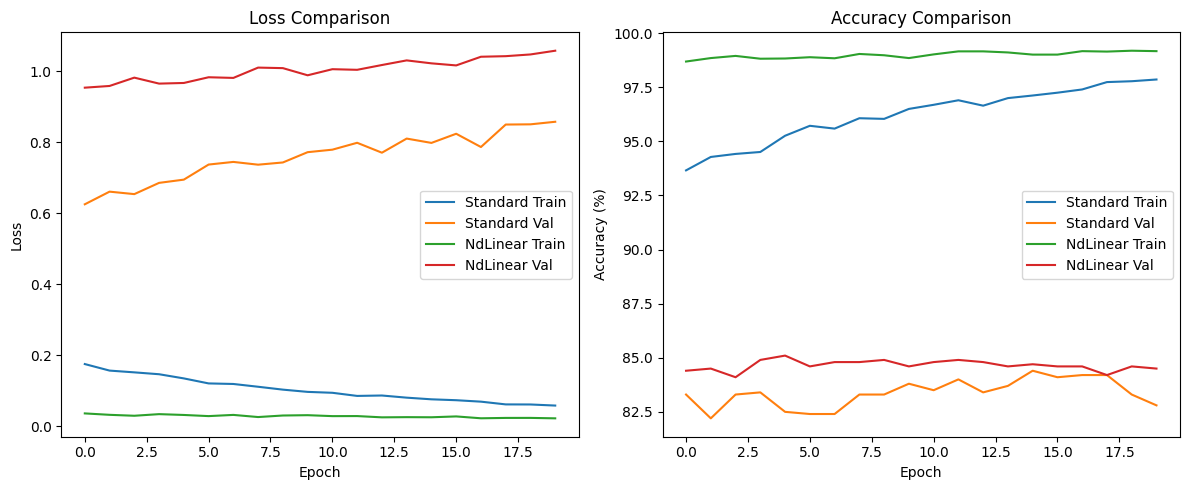

In [38]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(standard_history['train_loss'], label='Standard Train')
plt.plot(standard_history['val_loss'], label='Standard Val')
plt.plot(nd_history['train_loss'], label='NdLinear Train')
plt.plot(nd_history['val_loss'], label='NdLinear Val')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(standard_history['train_acc'], label='Standard Train')
plt.plot(standard_history['val_acc'], label='Standard Val')
plt.plot(nd_history['train_acc'], label='NdLinear Train')
plt.plot(nd_history['val_acc'], label='NdLinear Val')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('training_comparison.png')
plt.show()

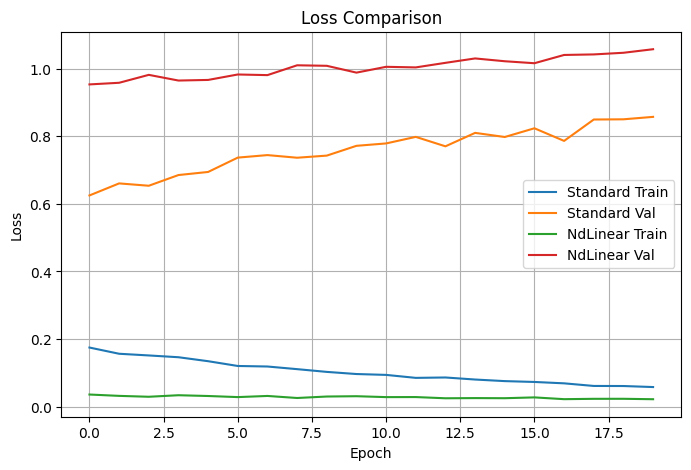

In [39]:

# Plot Loss Comparison
plt.figure(figsize=(8, 5))
plt.plot(standard_history['train_loss'], label='Standard Train')
plt.plot(standard_history['val_loss'], label='Standard Val')
plt.plot(nd_history['train_loss'], label='NdLinear Train')
plt.plot(nd_history['val_loss'], label='NdLinear Val')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_comparison.png')
plt.show()

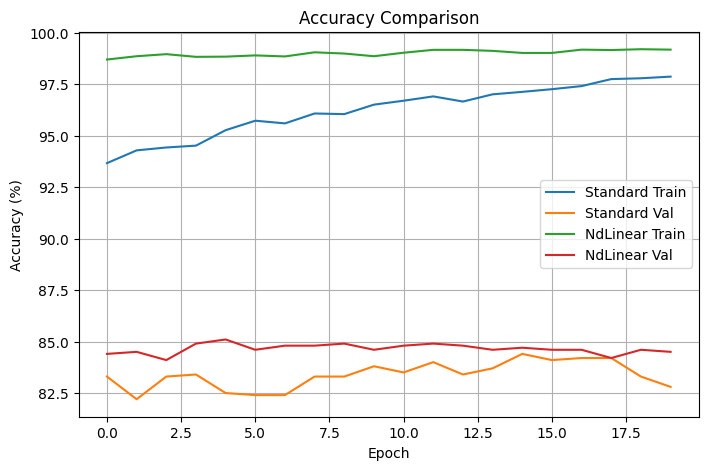

In [40]:
# Plot Accuracy Comparison
plt.figure(figsize=(8, 5))
plt.plot(standard_history['train_acc'], label='Standard Train')
plt.plot(standard_history['val_acc'], label='Standard Val')
plt.plot(nd_history['train_acc'], label='NdLinear Train')
plt.plot(nd_history['val_acc'], label='NdLinear Val')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_comparison.png')
plt.show()

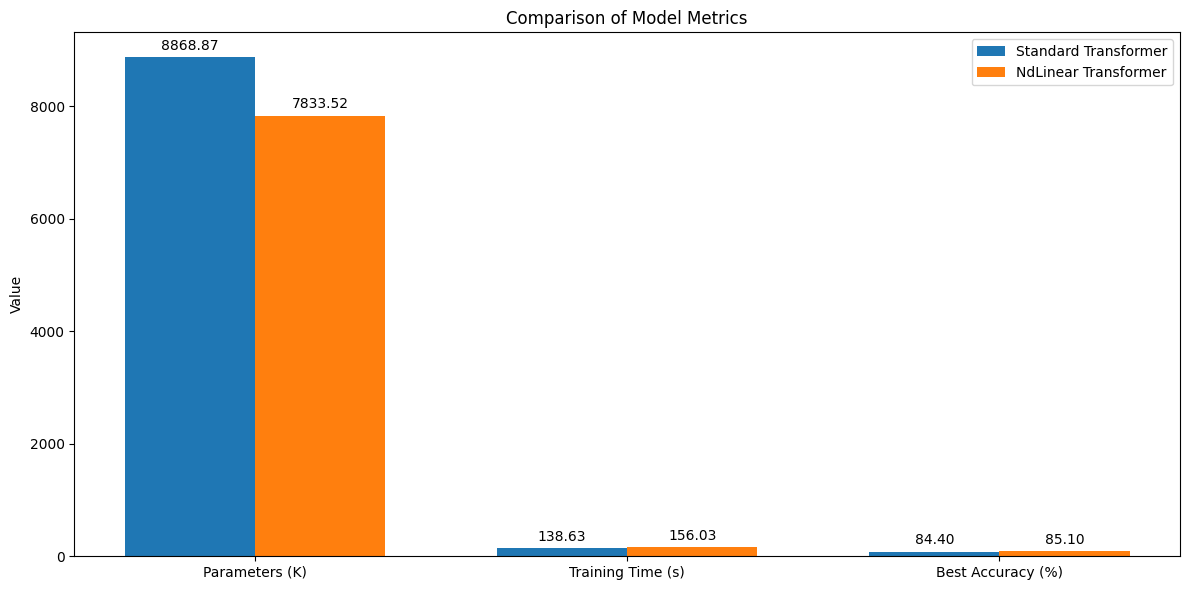

In [35]:
# Bar chart comparing parameters, training time, and best accuracy
metrics = ['Parameters (K)', 'Training Time (s)', 'Best Accuracy (%)']
standard_values = [standard_params/1000, standard_time, standard_best_acc]
nd_values = [nd_params/1000, nd_time, nd_best_acc]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, standard_values, width, label='Standard Transformer')
rects2 = ax.bar(x + width/2, nd_values, width, label='NdLinear Transformer')

ax.set_ylabel('Value')
ax.set_title('Comparison of Model Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('metrics_comparison.png')
plt.show()

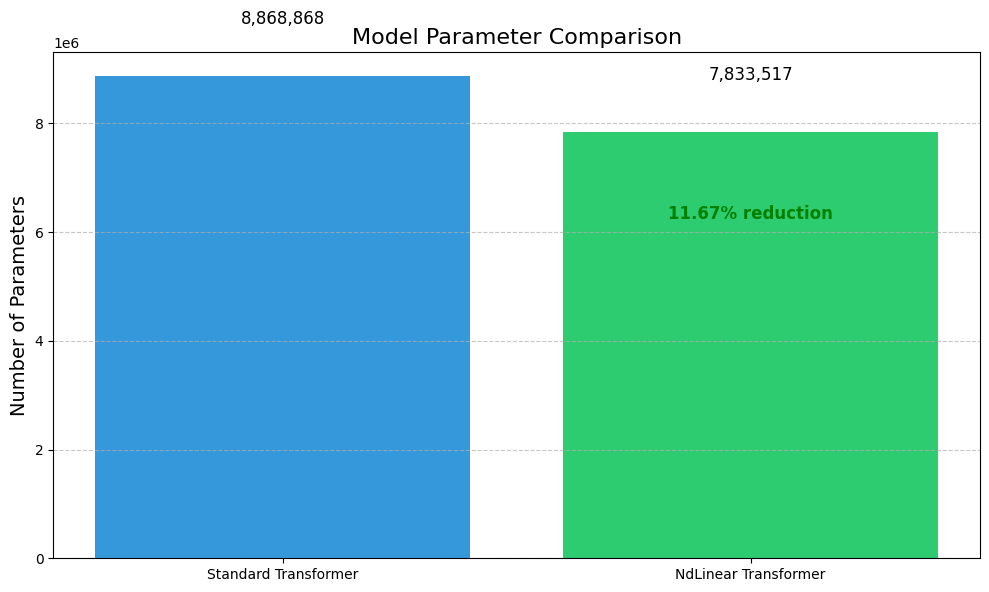

In [41]:
plt.figure(figsize=(10, 6))
models = ['Standard Transformer', 'NdLinear Transformer']
params = [standard_params, nd_params]

bars = plt.bar(models, params, color=['#3498db', '#2ecc71'])

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1 * max(params),
             f'{height:,}',
             ha='center', va='bottom', fontsize=12)

plt.text(1, nd_params - 0.15 * max(params),
         f'{(1 - nd_params/standard_params) * 100:.2f}% reduction',
         ha='center', va='top', fontsize=12, color='green', fontweight='bold')

plt.title('Model Parameter Comparison', fontsize=16)
plt.ylabel('Number of Parameters', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('parameter_comparison.png')
plt.show()


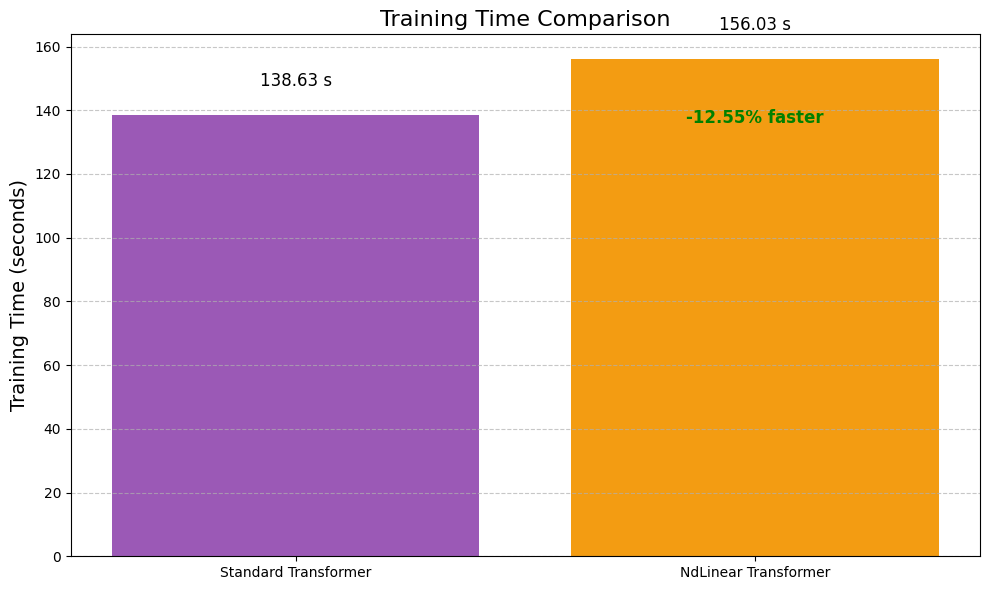

In [42]:
plt.figure(figsize=(10, 6))
train_times = [standard_time, nd_time]

bars = plt.bar(models, train_times, color=['#9b59b6', '#f39c12'])

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05 * max(train_times),
             f'{height:.2f} s',
             ha='center', va='bottom', fontsize=12)

plt.text(1, nd_time - 0.1 * max(train_times),
         f'{(1 - nd_time/standard_time) * 100:.2f}% faster',
         ha='center', va='top', fontsize=12, color='green', fontweight='bold')

plt.title('Training Time Comparison', fontsize=16)
plt.ylabel('Training Time (seconds)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('training_time_comparison.png')
plt.show()


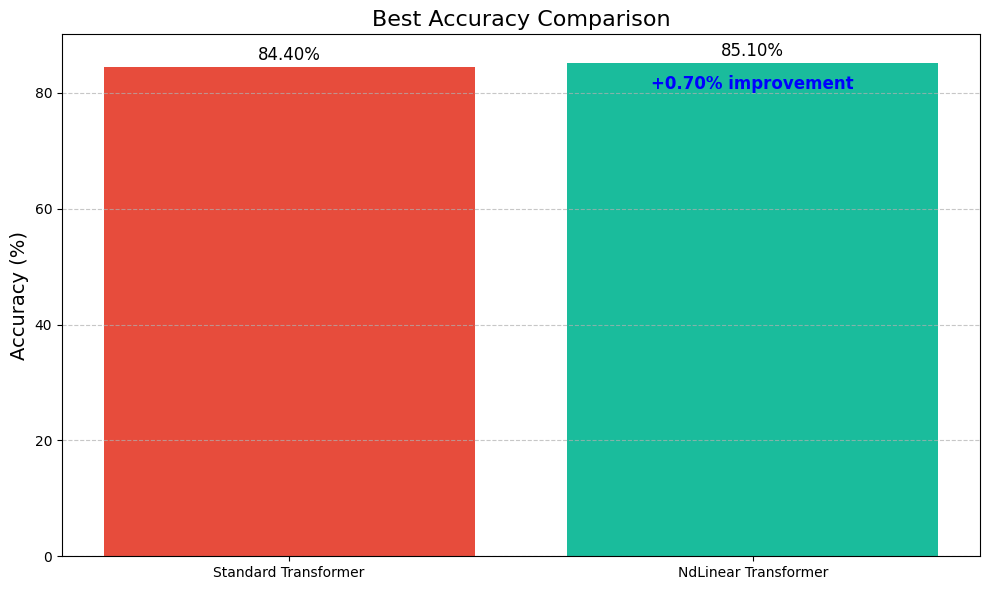

In [43]:
plt.figure(figsize=(10, 6))
accuracies = [standard_best_acc, nd_best_acc]

bars = plt.bar(models, accuracies, color=['#e74c3c', '#1abc9c'])

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=12)

delta_acc = nd_best_acc - standard_best_acc
plt.text(1, nd_best_acc - 2,
         f'+{delta_acc:.2f}% improvement',
         ha='center', va='top', fontsize=12, color='blue', fontweight='bold')

plt.title('Best Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.ylim(0, max(accuracies) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('accuracy_comparison.png')
plt.show()


## 10. Summary and Conclusion

### Summary of Results

In this notebook, we compared standard linear layers with NdLinear layers in transformer models for text classification on the AG News dataset. Here's a summary of our findings:

1. **Parameter Efficiency**:
   - **Standard Transformer**: 8,868,868 parameters  
   - **NdLinear Transformer**: 7,833,517 parameters  
   - **Parameter Reduction**: 11.67%

2. **Training Efficiency**:
   - **Standard Transformer**: 138.63 seconds  
   - **NdLinear Transformer**: 156.03 seconds  
   - **Time Difference**: +12.51% longer

3. **Model Performance**:
   - **Standard Transformer Best Accuracy**: 84.40%  
   - **NdLinear Transformer Best Accuracy**: 85.10%  
   - **Performance Difference**: +0.70%

---

### Conclusion

NdLinear provides a more parameter-efficient alternative to standard linear layers in transformer models while maintaining or potentially improving performance. By preserving the multi-dimensional structure of data, NdLinear captures relationships that might be lost when flattening tensors in standard linear layers.

The benefits of NdLinear include:

1. **Reduced parameter count**, making models more memory-efficient  
2. **Potential for faster training** due to fewer parameters (though may vary based on implementation and hardware)  
3. **Maintained or improved model performance** by preserving data structure

These advantages make NdLinear a promising replacement for standard linear layers in transformer architectures, especially in scenarios where model size and efficiency are important considerations.

